### Python recipe to read and plots the MJO RMM index(es) and calculate composite anomalies in the daily VCSN rainfall dataset for a given phase

### imports 

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
from datetime import datetime
from dateutil.parser import parse as dparse
import calendar

In [3]:
from IPython.display import IFrame

### below are the imports we need to make the map using [http://scitools.org.uk/cartopy/docs/latest/index.html](http://scitools.org.uk/cartopy/docs/latest/index.html)

In [4]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

/Users/nicolasf/anaconda/envs/IOOS/lib/python3.5/site-packages/matplotlib/ticker.py:1685: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


### this is where the Wheeler and Hendon (2004) realtime RMM index lives, and what it looks like

In [5]:
url = 'http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt'

In [6]:
IFrame(url, width=1100, height=500)

### reads in the RMM index using Pandas

In [7]:
data = pd.read_table(url, skiprows=2, sep=r'\s+', header=None)

In [8]:
data.head()

,0,1,2,3,4,5,6,7
0,1974,6,1,1.63447,1.20304,5,2.02948,Final_value:__OLR_&_NCEP_winds
1,1974,6,2,1.60289,1.01512,5,1.89729,Final_value:__OLR_&_NCEP_winds
2,1974,6,3,1.51625,1.08551,5,1.86476,Final_value:__OLR_&_NCEP_winds
3,1974,6,4,1.50981,1.03573,5,1.83092,Final_value:__OLR_&_NCEP_winds
4,1974,6,5,1.55906,1.30518,5,2.03326,Final_value:__OLR_&_NCEP_winds


### some data munging follows

#### renaming the columns

In [9]:
data.columns = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude', 'origin']

In [10]:
data.head()

,year,month,day,RMM1,RMM2,phase,amplitude,origin
0,1974,6,1,1.63447,1.20304,5,2.02948,Final_value:__OLR_&_NCEP_winds
1,1974,6,2,1.60289,1.01512,5,1.89729,Final_value:__OLR_&_NCEP_winds
2,1974,6,3,1.51625,1.08551,5,1.86476,Final_value:__OLR_&_NCEP_winds
3,1974,6,4,1.50981,1.03573,5,1.83092,Final_value:__OLR_&_NCEP_winds
4,1974,6,5,1.55906,1.30518,5,2.03326,Final_value:__OLR_&_NCEP_winds


#### set the index to be a datetime index

In [11]:
index = pd.to_datetime(data.loc[:,['year','month','day']])

In [12]:
data.index = index

In [13]:
data.head()

,year,month,day,RMM1,RMM2,phase,amplitude,origin
1974-06-01,1974,6,1,1.63447,1.20304,5,2.02948,Final_value:__OLR_&_NCEP_winds
1974-06-02,1974,6,2,1.60289,1.01512,5,1.89729,Final_value:__OLR_&_NCEP_winds
1974-06-03,1974,6,3,1.51625,1.08551,5,1.86476,Final_value:__OLR_&_NCEP_winds
1974-06-04,1974,6,4,1.50981,1.03573,5,1.83092,Final_value:__OLR_&_NCEP_winds
1974-06-05,1974,6,5,1.55906,1.30518,5,2.03326,Final_value:__OLR_&_NCEP_winds


In [14]:
data.tail()

,year,month,day,RMM1,RMM2,phase,amplitude,origin
2017-09-05,2017,9,5,0.515983,-0.455458,4,0.688245,Prelim_value:_OLR_&_ACCESS_wind
2017-09-06,2017,9,6,0.009035,-0.371963,3,0.372073,Prelim_value:_OLR_&_ACCESS_wind
2017-09-07,2017,9,7,-0.159914,-0.267640,2,0.311775,Prelim_value:_OLR_&_ACCESS_wind
2017-09-08,2017,9,8,-0.070005,-0.273755,2,0.282564,Prelim_value:_OLR_&_ACCESS_wind
2017-09-09,2017,9,9,-0.079875,-0.358170,2,0.366968,Prelim_value:_OLR_&_ACCESS_wind


### extracts the post 1979 period (no missing values)

In [15]:
data = data.loc['1979':,:]

In [16]:
data.head()

,year,month,day,RMM1,RMM2,phase,amplitude,origin
1979-01-01,1979,1,1,0.142507,1.05047,6,1.06009,Final_value:__OLR_&_NCEP_winds
1979-01-02,1979,1,2,-0.204200,1.37361,7,1.38870,Final_value:__OLR_&_NCEP_winds
1979-01-03,1979,1,3,-0.158610,1.53943,7,1.54758,Final_value:__OLR_&_NCEP_winds
1979-01-04,1979,1,4,-0.182450,1.45972,7,1.47108,Final_value:__OLR_&_NCEP_winds
1979-01-05,1979,1,5,-0.320050,1.13680,7,1.18100,Final_value:__OLR_&_NCEP_winds


### Now calculate and plot the composite anomalies -- for a given season -- in the VCSN daily rainfall dataset

### selects a season in the RMM index Dataframe, i.e. April - May - June

In [17]:
datas = data.loc[data.month.isin([4,5,6]),:]

In [18]:
datas.head()

,year,month,day,RMM1,RMM2,phase,amplitude,origin
1979-04-01,1979,4,1,0.343018,-1.12802,3,1.17902,Final_value:__OLR_&_NCEP_winds
1979-04-02,1979,4,2,0.330973,-1.43226,3,1.47000,Final_value:__OLR_&_NCEP_winds
1979-04-03,1979,4,3,0.620067,-1.66040,3,1.77240,Final_value:__OLR_&_NCEP_winds
1979-04-04,1979,4,4,0.847491,-1.69901,3,1.89865,Final_value:__OLR_&_NCEP_winds
1979-04-05,1979,4,5,0.972262,-1.80622,3,2.05127,Final_value:__OLR_&_NCEP_winds


In [19]:
datas.tail()

,year,month,day,RMM1,RMM2,phase,amplitude,origin
2017-06-26,2017,6,26,-0.448170,-0.513065,2,0.681243,Prelim_value:_OLR_&_ACCESS_wind
2017-06-27,2017,6,27,-0.665542,-0.857255,2,1.085280,Prelim_value:_OLR_&_ACCESS_wind
2017-06-28,2017,6,28,-0.557893,-1.113239,2,1.245209,Prelim_value:_OLR_&_ACCESS_wind
2017-06-29,2017,6,29,-0.410294,-1.062095,2,1.138590,Prelim_value:_OLR_&_ACCESS_wind
2017-06-30,2017,6,30,-0.414537,-0.883327,2,0.975760,Prelim_value:_OLR_&_ACCESS_wind


### below an example of how to get the dates for calculating the composite anomalies 

#### selects all days belonging to phase 3, with an amplitude exceeding 1 std

In [20]:
datas_phase_3 = datas.query("phase == 3 & amplitude >= 1")

In [21]:
datas_phase_3.head()

,year,month,day,RMM1,RMM2,phase,amplitude,origin
1979-04-01,1979,4,1,0.343018,-1.12802,3,1.17902,Final_value:__OLR_&_NCEP_winds
1979-04-02,1979,4,2,0.330973,-1.43226,3,1.47000,Final_value:__OLR_&_NCEP_winds
1979-04-03,1979,4,3,0.620067,-1.66040,3,1.77240,Final_value:__OLR_&_NCEP_winds
1979-04-04,1979,4,4,0.847491,-1.69901,3,1.89865,Final_value:__OLR_&_NCEP_winds
1979-04-05,1979,4,5,0.972262,-1.80622,3,2.05127,Final_value:__OLR_&_NCEP_winds


#### get the index and cast to a pydatetime type, we'll use this mechanism to select the sample in the VCSN dataset

In [22]:
index_composite_phase_3 = datas_phase_3.index.to_pydatetime()

In [23]:
index_composite_phase_3[-10:]

array([datetime.datetime(2016, 5, 16, 0, 0),
       datetime.datetime(2016, 5, 17, 0, 0),
       datetime.datetime(2016, 6, 18, 0, 0),
       datetime.datetime(2016, 6, 19, 0, 0),
       datetime.datetime(2016, 6, 20, 0, 0),
       datetime.datetime(2017, 5, 16, 0, 0),
       datetime.datetime(2017, 5, 29, 0, 0),
       datetime.datetime(2017, 5, 30, 0, 0),
       datetime.datetime(2017, 5, 31, 0, 0),
       datetime.datetime(2017, 6, 1, 0, 0)], dtype=object)

### read the VCSN daily rainfall anomalies

you need to change the path to something like `'S:/fauchereaun/Python_Workshop/data'` on Windows

In [24]:
dpath = os.path.join(os.environ['HOME'], 'drives/auck_scratch/fauchereaun/Python_Workshop/data')

In [25]:
fname = 'VCSN_daily_Rain_1981_2010_grid.anomalies.nc'

In [26]:
vcsn = xr.open_dataset(os.path.join(dpath, fname))

In [27]:
vcsn

<xarray.Dataset>
Dimensions:  (time: 13965, x: 243, y: 260)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 1979-01-03 ...
  * x        (x) float64 166.4 166.4 166.5 166.5 166.6 166.7 166.7 166.8 ...
  * y        (y) float64 -47.35 -47.3 -47.25 -47.2 -47.15 -47.1 -47.05 -47.0 ...
Data variables:
    mask     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Rain     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    CDI:                       Climate Data Interface version 1.7.1 (http://m...
    Conventions:               CF-1.4
    history:                   Tue May 09 10:53:01 2017: cdo ydaysub VCSN_dai...
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.7.1 (http://m...

#### get the lons and lats 

In [28]:
lon = vcsn['x']
lat = vcsn['y']

In [29]:
lons, lats = np.meshgrid(lon, lat)

### constrain the MJO time-series to conform to the range of dates in vcsn

In [30]:
vcsn.time[-1].data

numpy.datetime64('2017-03-26T00:00:00.000000000')

In [31]:
datas = datas.loc[None:vcsn.time[-1].data,:]

In [32]:
datas.tail()

,year,month,day,RMM1,RMM2,phase,amplitude,origin
2016-06-26,2016,6,26,1.327550,0.075436,5,1.329692,Prelim_value:_OLR_&_ACCESS_wind
2016-06-27,2016,6,27,1.256131,0.322341,5,1.296830,Prelim_value:_OLR_&_ACCESS_wind
2016-06-28,2016,6,28,0.678301,0.259862,5,0.726375,Prelim_value:_OLR_&_ACCESS_wind
2016-06-29,2016,6,29,-0.138567,0.451139,7,0.471940,Prelim_value:_OLR_&_ACCESS_wind
2016-06-30,2016,6,30,-0.431702,0.789323,7,0.899665,Prelim_value:_OLR_&_ACCESS_wind


### and now maps 

#### set up the projection (lat / lon), for a list of supported projections in cartopy, head to: 
    
    [http://scitools.org.uk/cartopy/docs/latest/crs/projections.html](http://scitools.org.uk/cartopy/docs/latest/crs/projections.html)

In [33]:
proj = ccrs.PlateCarree()

### defines the colormap 

In [34]:
cmap = plt.get_cmap('RdBu_r')

#### loops over the phases, calculate the composite anomalies and map, might take a minute or so to run

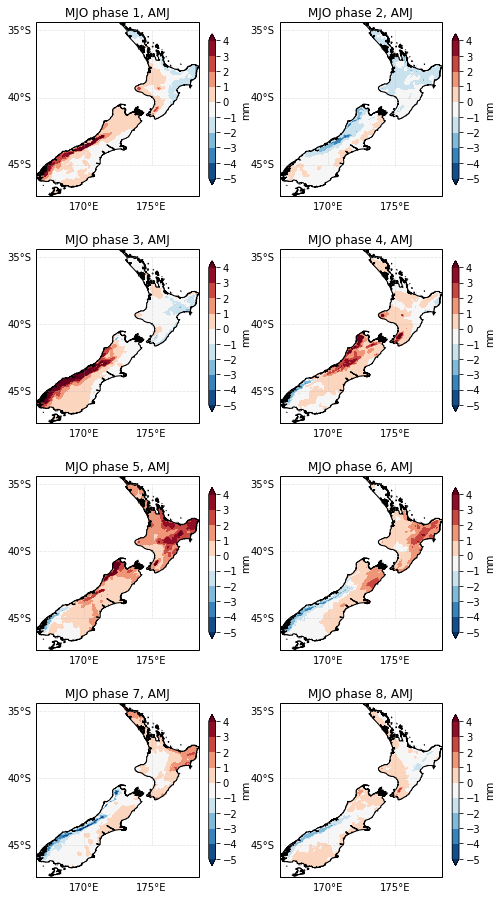

In [35]:
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 16), subplot_kw=dict(projection=proj))

axes= axes.flatten('C')

for i, phase in enumerate(range(1, 8 + 1)):

    ax=axes[i]

    index_compos = datas.query("phase == {} & amplitude >= 1".format(phase)).index.to_pydatetime()

    compos = vcsn.sel(time=index_compos).mean('time')
    
    # set the lat and lon limits of the maps 

    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
    
    # add the coastline
    
    ax.add_feature(cfeature.GSHHSFeature(scale='full'))
    
    # filled contour of the anomalies
    
    im = ax.contourf(lon, lat, compos['Rain'], levels=np.arange(-5, 5, 1), cmap=cmap, extend='both', transform=proj)
    
    # add the colorbar and its label
    
    cb = plt.colorbar(im, shrink=0.8, ax=ax)
    
    cb.set_label('mm')
    
    # add the grid lines and their labels
    
    gl = ax.gridlines(draw_labels=True, lw=0.5, linestyle=':', xlocs=np.arange(165., 185., 5.), ylocs=[-45., -40., -35.])

    gl.xlabels_top = gl.ylabels_right = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # add the title 
    
    ax.set_title("MJO phase {}, AMJ".format(phase))
    
    # close the xarray dataset containing the composite
    
    compos.close()
    
    
# saves to disk: you need to probably change the path
    
f.savefig('../images/composite_anomalies_MJO_AMJ.png', dpi=200)

### don't forget to close the VCSN dataset

In [36]:
vcsn.close()